# BASIC CONFIGURATIONS

In [1]:
### Setup the library ###
import pyrogue as pr
import os, sys
import matplotlib.pyplot as plt
import time
import datetime
import numpy as np
import math
import pprint
import inspect 
top_level=f'{os.getcwd()}/../'
rootTopLevel = top_level+'script/'
pr.addLibraryPath( rootTopLevel )

import setupLibPaths

import ePix320kM as devBoard

args = None

In [2]:
# ONLY RUN ONCE!
# Defining root
root =  devBoard.Root(   
        top_level  = rootTopLevel,
        dev        = '/dev/datadev_0',
        pollEn     = False,
        initRead   = True,
        serverPort = 9099)
root.start()

# example showing a read
AxiVersion = root.Core.AxiVersion
print ( '###################################################')
print ( '#             Firmware Version                    #')
print ( '###################################################')
AxiVersion.printStatus()
print ( '###################################################')

Root.Core.Si5345Pll.Page0.DataBlock.setPollInterval(1)
Start: Started zmqServer on ports 9099-9101
    To start a gui: python -m pyrogue gui --server='localhost:9099'
    To use a virtual client: client = pyrogue.interfaces.VirtualClient(addr='localhost', port=9099)
Root.Core.AxiVersion count reset called
###################################################
#             Firmware Version                    #
###################################################
Path         = Root.Core.AxiVersion
FwVersion    = 0x1000000
UpTime       = 1:19:06
GitHash      = 0xf8dcf569595edc8151899be9b0a4dc7ac352bf98
XilinxDnaId  = 0x400200000139d7204c80e045
FwTarget     = ePixHRM320k
BuildEnv     = Vivado v2022.1
BuildServer  = rdsrv314 (Ubuntu 20.04.6 LTS)
BuildDate    = Tue 01 Aug 2023 11:13:23 AM PDT
Builder      = dnajjar
###################################################


In [3]:
#Run this from a teminal in your localhost without the (!). If you run it here, it will open on rdsrv314 Jupyter server terminal and you won't see it.
#!python -m pyrogue gui --server='rdsrv314:9099'

In [3]:
# Useful short names
APP  = root.App
AXIV = root.Core.AxiVersion
ASICTOP = APP.AsicTop
TRIG = ASICTOP.TriggerRegisters
ASIC0 = APP.Mv2Asic[0]
ASIC1 = APP.Mv2Asic[1]
ASIC2 = APP.Mv2Asic[2]
ASIC3 = APP.Mv2Asic[3]
HSDAC = APP.Dac.FastDac 
PKREG0 = ASICTOP.DigAsicStrmRegisters0
PKREG1 = ASICTOP.DigAsicStrmRegisters1
PKREG2 = ASICTOP.DigAsicStrmRegisters2
PKREG3 = ASICTOP.DigAsicStrmRegisters3
BATCHER0 = ASICTOP.BatcherEventBuilder0
BATCHER1 = ASICTOP.BatcherEventBuilder1
BATCHER2 = ASICTOP.BatcherEventBuilder2
BATCHER3 = ASICTOP.BatcherEventBuilder3
DEBUG0 = root._dbg[0]
DEBUG1 = root._dbg[1]
DEBUG2 = root._dbg[2]
DEBUG3 = root._dbg[3]
DATARCV0 = root.DataReceiver0
DATARCV1 = root.DataReceiver1
DATARCV2 = root.DataReceiver2
DATARCV3 = root.DataReceiver3
FULLRATERCV0 = root.fullRateDataReceiver[0]
FULLRATERCV1 = root.fullRateDataReceiver[1]
FULLRATERCV2 = root.fullRateDataReceiver[2]
FULLRATERCV3 = root.fullRateDataReceiver[3]
DAC = APP.Dac

In [4]:
# Set & Read ScratchPad
print(hex(AXIV.ScratchPad.get()))
AXIV.ScratchPad.set(0xdeadbeef)
print(hex(AXIV.ScratchPad.get()))

0xdeadbeef
0xdeadbeef


In [5]:
# Configure clock to 168 MHz and configures all ASICS
root.InitASIC([3,1,1,1,1])

Rysync ASIC started
Init ASIC script started
Loading PLL configuration
Root.Core.Si5345Pll.LoadCsvFile(): /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/../script/../config/EPixHRM320KPllConfig168Mhz.csv
Loaded. Waiting for lock...
Loading supply configuration
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_PowerSupply_Enable.yml
Loading lane delay configurations
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_SspMonGrp_carrier3.yml
Loading waveforms configuration
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_RegisterControl.yml
Loading packet registers
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/noteb

# Disable full rate receivers for now

In [5]:
root.disableAndCleanAllFullRateDataRcv()
root.enableDataRcv(False)
root.enableDataDebug(False)

# Single image acquire example

In [6]:
root.enableAllAsics(True)
root.enableDataRcv(False)
#run some triggers and exercise lanes and locks
frames = 5000
rate = 1000
root.hwTrigger(frames, rate)

Stop Triggers command executed
Set Auto Trigger command executed
Start Auto Trigger command executed
Triggers sent: 5000
Stop Triggers command executed


In [7]:
#get locked lanes
root.getLaneLocks()

ASIC0: 0xffffff
ASIC1: 0xfffffe
ASIC2: 0x36ffff
ASIC3: 0xffffff


In [8]:
#Disabled lanes in ASICS
for asicIndex in range(4) : 
    root.App.AsicTop.DigAsicStrmRegisters0.enable.set(True)
    print("ASIC{}: {:#x}".format(asicIndex, getattr(root.App.AsicTop, f"DigAsicStrmRegisters{asicIndex}").DisableLane.get()))


ASIC0: 0x0
ASIC1: 0x1
ASIC2: 0xc90000
ASIC3: 0x0


In [8]:
#Enable data receivers and run some triggers
root.enableDataRcv(True)
root.Trigger()

In [9]:
# Obtain descrambled single frame data from ASICs from DataReceiver. Data receiver is down sampled.
root.printDataReceiverStatus()
    
frame = [None for i in range(4)]
for asicIndex in range(4):
    frame[asicIndex] = getattr(root, f"DataReceiver{asicIndex}").Data.get()


Checkpoint: DataReceiver 0 has 1 frames
Checkpoint: DataReceiver 1 has 1 frames
Checkpoint: DataReceiver 2 has 1 frames
Checkpoint: DataReceiver 3 has 1 frames


In [10]:
#frame dimensions
for asicIndex in range(root.numOfAsics):
    print(np.shape(frame[asicIndex]))

(192, 384)
(192, 384)
(192, 384)
(192, 384)


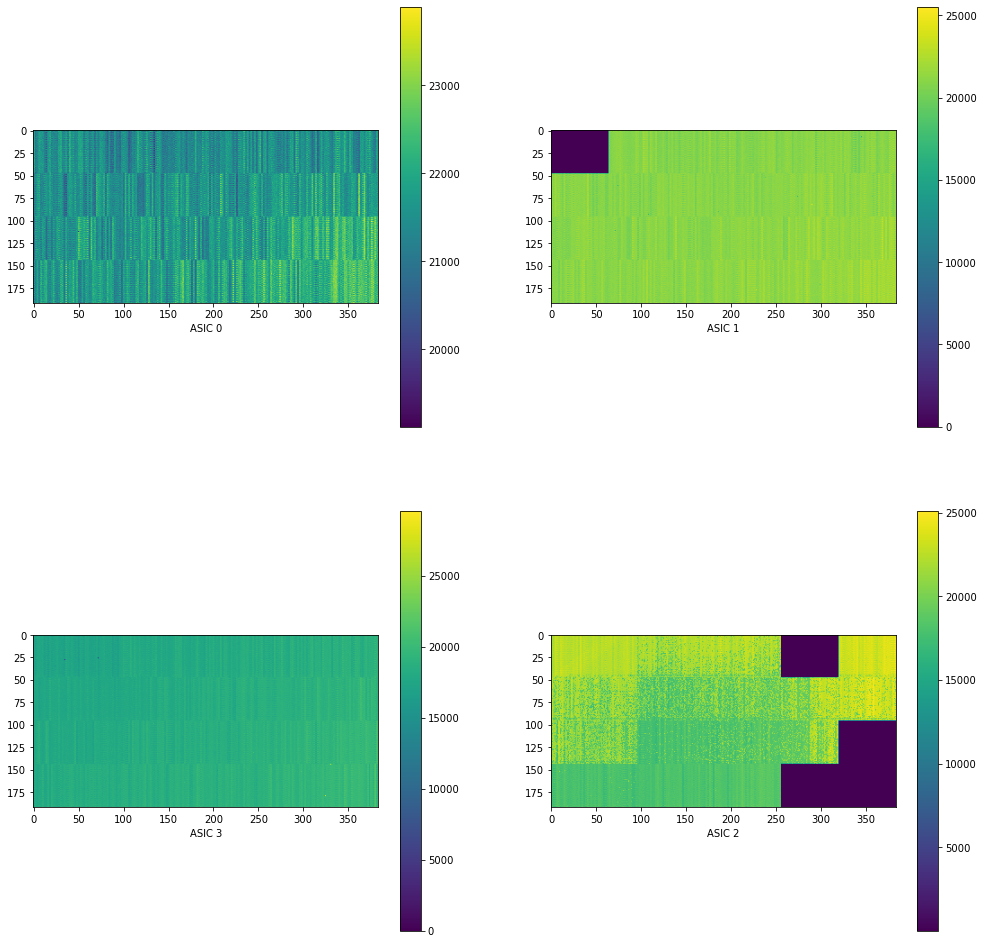

In [11]:
#plot image
plt.subplots(2,2,figsize=(17,17))
for asicIndex in range(root.numOfAsics):
    if asicIndex == 3 :
        plt.subplot(2,2,3)
    elif asicIndex == 2 :
        plt.subplot(2,2,4)
    else :
        plt.subplot(2,2,asicIndex+1)
    
    if np.shape(frame[asicIndex])[0] != 1 :
        plt.imshow(frame[asicIndex])
        plt.xlabel("ASIC {}".format(asicIndex))
        plt.colorbar()
    else :
        plt.xlabel("ASIC {}: No data".format(asicIndex))

In [28]:
#Manipulate ASIC register
for asicIndex in range(root.numOfAsics) : 
    root.App.Mv2Asic[asicIndex].enable.set(True)
    root.App.Mv2Asic[asicIndex].mTest.set(True)
    root.App.Mv2Asic[asicIndex].mTest.set(False)

ASIC3.mTest.set(False)

In [13]:
#Clean up
root.enableDataRcv(False)

# Full acquisition of descrambled data in numpy array example

In [36]:
# Perform descrambled acquisition using debug class without writing to file.
root.enableAllAsics(False)
root.enableAsic(3, True)
DEBUG3.enableDataDebug()
DEBUG3.cleanData()
numberOfTriggers = 100
for asicIndex in range(numberOfTriggers):
    root.Trigger()
    print("{}".format(asicIndex+1), end='\r')
    time.sleep(0.01)

In [38]:
# Although the triggers above may have finished, descrambling takes time
while ( numberOfTriggers != DEBUG3.getData().shape[2]) :
    time.sleep(0.1)
    print("Descrambled {}".format(DEBUG3.getData().shape[2]), end='\r')
print("Data Descrambled")
print(DEBUG3.getData().shape)

KeyboardInterrupt: 

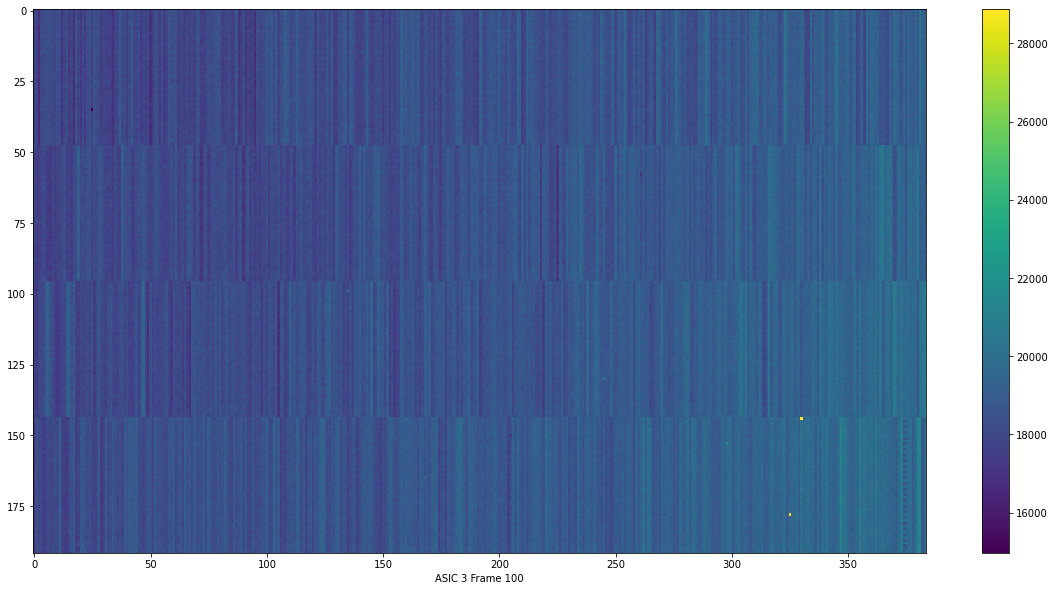

In [18]:
#Display image. Note that Interpolation is enabled. That is similar to auto contrast
plt.figure(figsize = (20,10))
plt.imshow(DEBUG3.getData()[:,:,99], interpolation='nearest', aspect='auto')
plt.xlabel("ASIC 3 Frame 100")
plt.colorbar()

In [19]:
# Disable data debug so it does not store data infinitely and crash software
DEBUG3.cleanData()
print(DEBUG3.getData().shape)
DEBUG3.disableDataDebug()

(192, 384, 0)


# Using fullRateReceiver class for acquisition with dark application

In [4]:
# Full rate reciever is slower than debug class, but it provides extra processing like applying dark
root.enableFullRateDataRcv(3, True)
FULLRATERCV3.cleanData()

In [5]:
# apply dark to next image
FULLRATERCV3.ApplyDark.set(False)
FULLRATERCV3.DarkReady.set(False)
FULLRATERCV3.NumDarkReq.set(1)
FULLRATERCV3.CollectDark.set(True)
while (FULLRATERCV3.DarkReady.get() == False) :
    root.Trigger()
    time.sleep(1)
FULLRATERCV3.ApplyDark.set(True)



*****Dark ready*****



In [6]:
FULLRATERCV3.cleanData()
root.Trigger()

# descrambling requires some time
while ( 1 != FULLRATERCV3.getData().shape[2]) :
    time.sleep(0.1)

print(FULLRATERCV3.getData().shape)

(192, 384, 1)


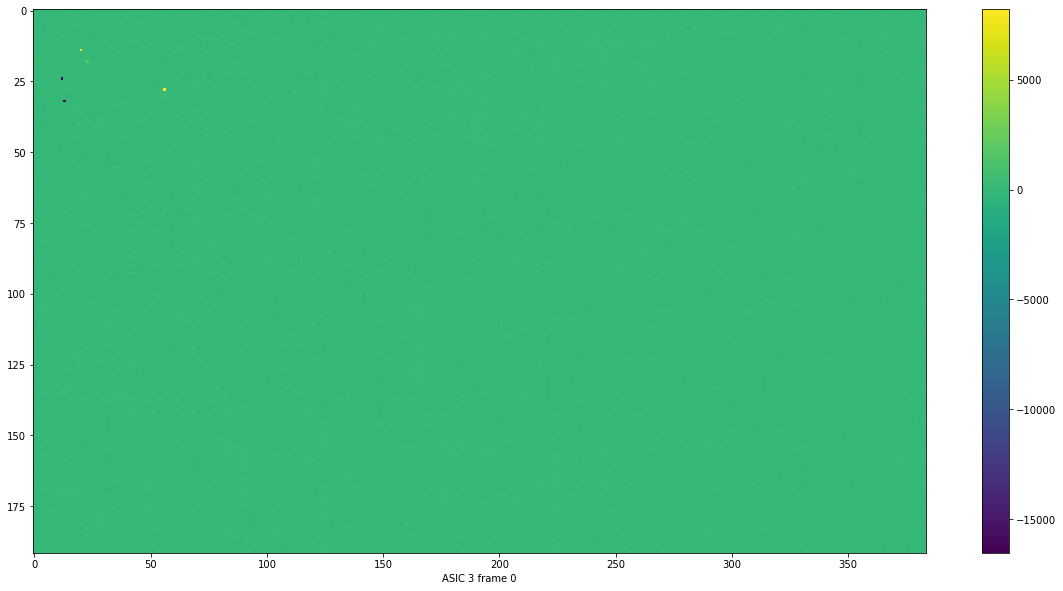

In [7]:
# Display image
plt.figure(figsize = (20,10))
plt.imshow(FULLRATERCV3.getData()[:,:,0], interpolation='nearest', aspect='auto')
plt.xlabel("ASIC 3 frame 0")
plt.colorbar()

# Charge Injection

In [4]:
# If you want to apply generated in the previous section do not run this!!!
root.enableFullRateDataRcv(3, True)
FULLRATERCV3.ApplyDark.set(False)

In [12]:
FULLRATERCV3.cleanData()

asicIndex = 3
chargeInjectionFirstCol = 50
chargeInjectionLastCol = 100
chargeInjectionPulserValue = 0
APP.prepareChargeInjection(asicIndex, chargeInjectionFirstCol, chargeInjectionLastCol, chargeInjectionPulserValue)
root.Trigger()

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [13]:
print(FULLRATERCV3.getData().shape)

(192, 384, 1)


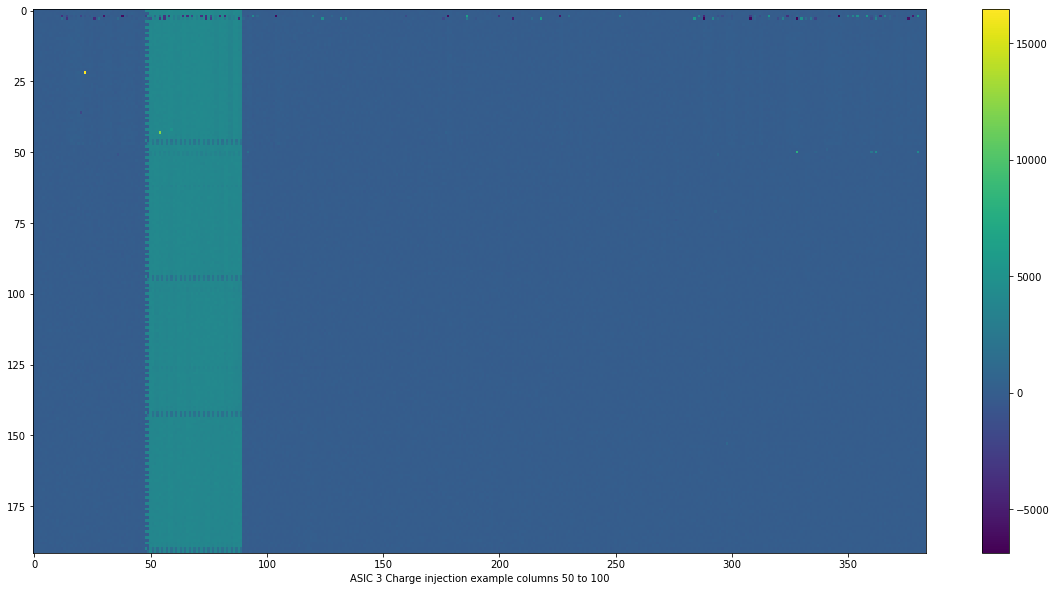

In [14]:
# Display image
plt.figure(figsize = (20,10))
plt.imshow(FULLRATERCV3.getData()[:,:,0], interpolation='nearest', aspect='auto')
plt.xlabel("ASIC 3 Charge injection example columns 50 to 100")
plt.colorbar()

In [15]:
APP.chargeInjectionCleanup(3)

# With dark multiple frame acquisition

In [32]:
# If dark was disabled in the previous section you need to run dark again
FULLRATERCV3.cleanData()

numberOfTriggers = 100
for asicIndex in range(numberOfTriggers):
    root.Trigger()
    print("{}".format(asicIndex+1), end='\r')
    time.sleep(0.01)

In [36]:
# Run multiple times to see processed frames
np.shape(FULLRATERCV3.getData())

(192, 384, 100)

In [37]:
# Although the triggers above may have finished, descrambling takes time
while ( numberOfTriggers != FULLRATERCV3.getData().shape[2]) :
    time.sleep(0.1)
    print("Processed {}".format(FULLRATERCV3.getData().shape[2]), end='\r')
print("Data processed")
print(FULLRATERCV3.getData().shape)

Data processed
(192, 384, 100)


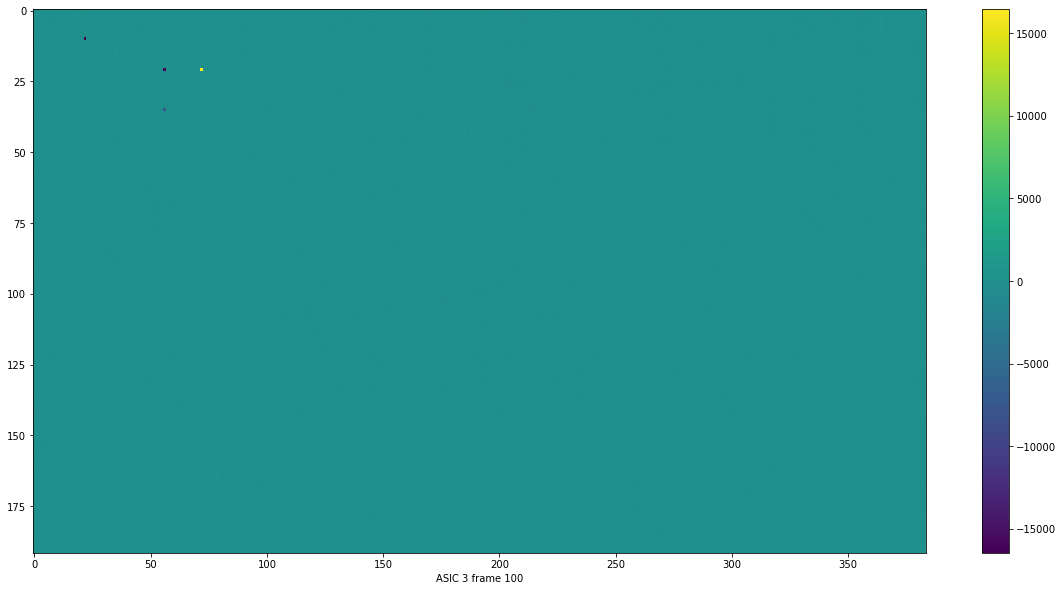

In [38]:
# Display image
plt.figure(figsize = (20,10))
plt.imshow(FULLRATERCV3.getData()[:,:,40], interpolation='nearest', aspect='auto')
plt.xlabel("ASIC 3 frame 100")
plt.colorbar()

In [39]:
# cleanup
# root.disableAndCleanAllFullRateDataRcv()

# ADC Response with external DAC

In [8]:
# User ASIC 3
ASIC3.mTest.set(True)

In [9]:
first = 0x0
last = 0xfffff
step = 0xffff
DAC.setupFastDacWaveform(first, last, step)

In [12]:
FULLRATERCV3.cleanData()

#run some triggers and exercise lanes and locks
frames = 16
rate = 2
root.hwTrigger(frames, rate)

Stop Triggers command executed
Set Auto Trigger command executed
Start Auto Trigger command executed
Triggers sent: 16
Stop Triggers command executed


In [13]:
# Although the triggers above may have finished, descrambling takes time
while ( frames != FULLRATERCV3.getData().shape[2]) :
    time.sleep(0.1)
    print("Processed {}".format(FULLRATERCV3.getData().shape[2]), end='\r')
print("Data processed")
print(FULLRATERCV3.getData().shape)

Data processed
(192, 384, 16)


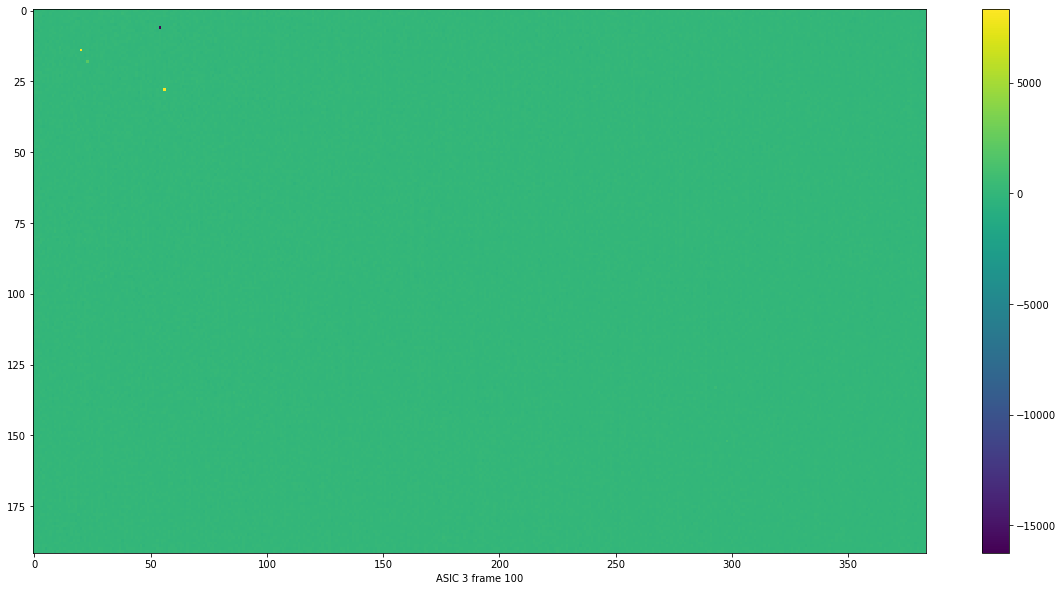

In [16]:
# Display image
plt.figure(figsize = (20,10))
plt.imshow(FULLRATERCV3.getData()[:,:,0], interpolation='nearest', aspect='auto')
plt.xlabel("ASIC 3 frame 100")
plt.colorbar()

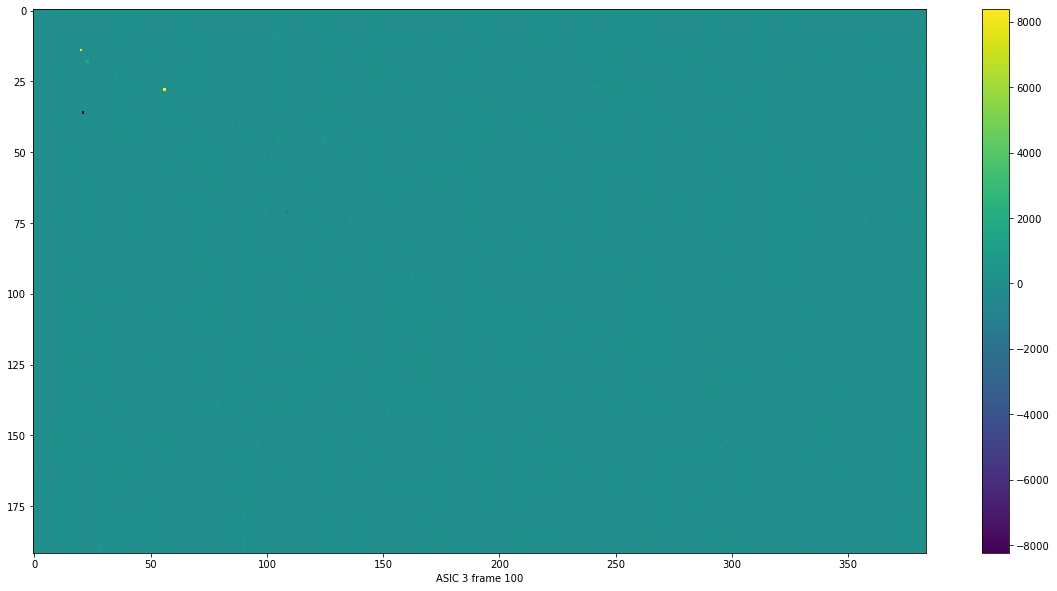

In [17]:
# Display image
plt.figure(figsize = (20,10))
plt.imshow(FULLRATERCV3.getData()[:,:,15], interpolation='nearest', aspect='auto')
plt.xlabel("ASIC 3 frame 100")
plt.colorbar()

In [ ]:
DAC.cleanupFastDacWaveform()

# Using writer and converting to HDF5

In [50]:
root.enableDataRcv(False)
root.disableAndCleanAllFullRateDataRcv()
root.enableAllAsics(False)
root.enableAsic(0, True)

filename = "test.dat"
rate = 100 # HZ
frames = 1000
root.acquireToFile(filename, frames, rate)

Acquisition started: filename: test.dat, rate: 1000, #frames:100
Stop Triggers command executed
Set Auto Trigger command executed
Start Auto Trigger command executed
Triggers sent: 1000
Stop Triggers command executed
Received 901 frames...
 waiting for file to close...
Total triggers sent: 1000
File closed. Acquisition complete. Frames acquired: 901


In [38]:
"""
CONVERT: DAT TO HDF5
"""
# --- FAST MULTI-CORE METHOD --- #
# Note: For 130k frames at x20 cores, takes ~1.5 hours
DAT_to_HDF5 = '{}/imgProc/read_image_from_file_ePixMHrv2.py'.format(rootTopLevel)
print('Waiting... runing in process... when * changes to a number then done')
%run {DAT_to_HDF5} {filename} {"--cores=10"}
print("HDF5 generation complete")

Waiting... runing in process... when * changes to a number then done
Starting to get data set 0
Message

file: <_io.BufferedReader name='test.dat'>

size [   46996 33554434] previous size [  147508 33554434]
numberOfFrames read:  40
Message

file: <_io.BufferedReader name='test.dat'>

size [   91780 33554434] previous size [  147508 33554434]
numberOfFrames read:  490
Message

file: <_io.BufferedReader name='test.dat'>

size [  137236 33554434] previous size [  147508 33554434]
numberOfFrames read:  718
Message

file: <_io.BufferedReader name='test.dat'>

size [    9844 33554434] previous size [  147508 33554434]
numberOfFrames read:  742
Message

file: <_io.BufferedReader name='test.dat'>

size [] previous size [  147508 33554434]
numberOfFrames read:  898
Camera  ePixHrMv2  selected.
numberOfFrames in the 3D array:  898
Starting descrambling images
Saving Hdf5
(192, 384)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0